### Import libraries:

In [1]:
### General library library:
import re, glob
import requests
import pdb
import xml.etree.ElementTree as ET
from collections import defaultdict
import sys, os, datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib

### in order to use dsp package we need this line of code:
sys.path.append('/mar/home/pzaeri/Parisa/dsp/') 

### Importing dsp package and related library to sound file:
from soundfile import SoundFile
from dsp.SampleStream import SampleStream, Streams
from dsp.DFTStream import DFTStream

Using matplotlib backend: Qt5Agg


 `all_three` -is list of `.wav` files in paths:
1. `/mar/lab/corpora/SitePreamp/pacific_white-sided_a/`
2. `/mar/lab/corpora/SitePreamp/pacific_white-sided_b/`
3. `/mar/lab/corpora/SitePreamp/rissos_dolphin/`

In [2]:
fldr = '/mar/lab/corpora/SitePreamp'
all_three = list(glob.iglob(fldr + '/**/*.x.wav', recursive=True))
# print(all_three)

# first = all_three[0]
# first

<br><br>

### Define a function that returns the start time of a given `.x.wav` file:
`os.path.split(path)`: Split the *pathname path* into a pair, **(head, tail)** where **tail** is the **last pathname** component and **head** is everything **leading up to that**. The tail part will never contain a slash; if path ends in a slash, tail will be empty. If there is no slash in path, head will be empty. If path is empty, both head and tail are empty. Trailing slashes are stripped from head unless it is the root (one or more slashes only). In all cases, join(head, tail) returns a path to the same location as path (but the strings may differ). For example: 

```
spl = os.path.split('/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061129_192230.x.wav')
head = spl[0]
tail = spl[1]
```
head : /mar/lab/corpora/SitePreamp/pacific_white-sided_b
<br>
tail :  SOCAL08A_sitA_061129_192230.x.wav

<br><br>

In [2]:
def get_start_timestamp(wav_f, format_str = "%y%m%d_%H%M%S"):
    ''' 
    Given a wav_f(.x.wav) returns the datetime of the start of the file
    
    Input:
        wav_f - filename(.x.wav)
        format_str = output desired format (default="%y%m%d_%H%M%S")
    '''
    
    fname = os.path.split(wav_f)[1]
#     print(fname)
    
    match_date = re.search(r'\d{8}_\d{6}', fname)
    
    try:
        # Cornell Format
        start_time = datetime.datetime.strptime(match_date.group(), format_str)
    except AttributeError:
        try:
            # not cornell format try scripps format
            match_date = re.search(r'\d{6}_\d{6}', fname)
            start_time = datetime.datetime.strptime(match_date.group(), format_str)
     
        except AttributeError:
            print('format not recognized- figure out how to implement optional\
                  recursion as an input.')
    return(start_time)

In [3]:
def parse_start_end_detection(dot_ext_path_ls):
    start_end_det = []
    for dot_file in dot_ext_path_ls:
        with open(dot_file, 'r') as file:
            this_file = []
            for line in file:
                elements = line.split()
                start_det = elements[0]
                end_det = elements[1]
                this_file.append((start_det, end_det))
        start_end_det.append(this_file)
    return start_end_det

## For test only:

In [4]:
####### test:
two = ['/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL10G_sitG_070124_114230.x.wav',
            '/mar/lab/corpora/SitePreamp/rissos_dolphin/SCAL31G2_stG2_090223_132845.x.wav']
dot_c = ['/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL10G_sitG_070124_114230.c',
            '/mar/lab/corpora/SitePreamp/rissos_dolphin/SCAL31G2_stG2_090223_132845.c']

samples_for_all_files = []


# For each stream(we have 132 files --> 132 streams), 
# each detection(every row in every file) read the samples, that is:
# iterate through the the .x.wav files and make a list of all (132 files) 
# which inside every of those lists  for samples that has all 132 
# streams of 132 .x.wav files:
for counter, wav_file in enumerate(two):
    aa = SoundFile(wav_file)
    
    # `start` varibale below is the absolute start time of the file. For example
    # one of our '.c'(i.e. `pacific_white-sided_b/SOCAL10G_sitG_070124_114230.c`)
    # files starts at 2007/01/24 11:42:30sec according to this part:
    # 070124_114230):
    start = get_start_timestamp(wav_file)
    
    # declare the stream which will contain a list of all of the .x.wav 
    # files:
    stream_elements = Streams()
    stream_elements.add_file(wav_file, [len(aa)], [start], aa.samplerate)
    sound_stream = SampleStream(stream_elements)
    samples_for_current_file = []
    
    #iterate through 132 files:
    for detection in parse_start_end_detection(dot_c)[counter]:
        
        # start_det(first element in each row in a '.c' file) is the 
        # relative (seconds parts) offset into the file 
        # i.e. (relative to the 'start' variable. 
        start_det = float(detection[0])
        end_det = float(detection[1])
        
        #start_timestamp is the absolute start time of the current detection
        start_timestamp = start + datetime.timedelta(seconds=start_det)
        sound_stream.set_time(start_timestamp)
        samps = sound_stream.read(int((end_det-start_det) * aa.samplerate))
        samples_for_current_file.append(samps)
    
    samples_for_all_files.append(samples_for_current_file)

/mar/home/pzaeri/Parisa/dsp/dsp/SampleStream.py:383: RuntimeWarning: invalid value encountered in multiply
  self._hist = np.empty([self._hist_size, self.stream.channels]) * np.NaN


In [5]:
##### Self-test:

## `samples_for_all_files[0]`(1st file) includes 2705 tuples
## (one tuple per each row) and each tuple has 5 elemnts inside it:
print("Total number of rows(detections) in the first file(pacific_white-sided_b/SOCAL10G_sitG_070124_114230.c) in `samples_for all_files` = ",
      len(samples_for_all_files[0]), '\n')

## `samples_for_all_files[1]`(2nd file) includes 684 tuples
## (one tuple per each row) and each tuple has 5 elemnts inside it:
print("Total number of rows(detections) in the second file(rissos_dolphin/SCAL31G2_stG2_090223_132845.c) in `samples_for all_files` = ", 
      len(samples_for_all_files[1]),'\n')
print("samples_for_all_files[0][2704] = last row of first file(pacific_white-sided_b/SOCAL10G_sitG_070124_114230.c) =",
     samples_for_all_files[0][2704], '\n')

## `dets` variable in below's code is tuples of (1st_element , 2nd_element)
## of all detections(rows) in the first file(shows with [0])
## (pacific_white-sided_b/SOCAL10G_sitG_070124_114230.c):
dets = parse_start_end_detection(dot_c)[0]

## below's variable is start time of the file is 11h:42m:30sec
## (absolute start time):
Absolute_start_of_file_SOCAL10G_sitG_070124_114230_timestamp = get_start_timestamp('/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL10G_sitG_070124_114230.x.wav')
print('Absolute_start_of_file_SOCAL10G_sitG_070124_114230_timestamp =', 
      Absolute_start_of_file_SOCAL10G_sitG_070124_114230_timestamp, '\n')

## below's variable is the absolute time of the first detection.
## So, first row, first element of the file is 12.116660sec, therefore
## this will add up to the seconds in our absolute start time above which is 
## going to be our first start time detection = 11:42:(30+12.116660=42.116660)
## Note that we care about only the start time of detection 
## not end of each detection(2nd element in each row): 
Absolute_start_of_detection_timestamp = Absolute_start_of_file_SOCAL10G_sitG_070124_114230_timestamp + datetime.timedelta(seconds=float(dets[0][0]))
print('Absolute start time of the file + first row and first element(i.e. first start time detection) of the same file', 
      Absolute_start_of_detection_timestamp, '\n')

## In the code below, in `samples_for_all_files[0][0][0]` variable:
### First [] from the left means which file - The example we have here 
## because we only have 2 files, therefore first square bracket([0])
## is the file `pacific_white-sided_b/SOCAL10G_sitG_070124_114230.c`
### Second [] is referring to the rows(detections) inside the file. For 
## example [0] means 1st row(detection) out of 2705 rows that exists in our
## first file(`pacific_white-sided_b/SOCAL10G_sitG_070124_114230.c`)
## Note that in first file we have 2705 tuples with 5 elements inside it.
### Third [] picks which element in the tuple of length 5 we want to select.
## For example if we select [0], we pick 1st element in this tuple which is 
## an array of total number of samples from our second []( row selection:
print('Array of total # of samples(which has 3000 elements in it) in first detection(row) in our first file =',
      samples_for_all_files[0][0][0])
print('shape of the array in samples_for_all_files[0][0][0] =', 
      (samples_for_all_files[0][0][0]).shape, '\n')

## First row(detection) of our first file  
## (pacific_white-sided_b/SOCAL10G_sitG_070124_114230.c)
## with total number of rows(detections) = 2705 inside it:
print('dets[0] equivalent to our first row(detection) in our file  =', 
      dets[0], '\n')

print('dets[2704] equivalent to our last row(detection) in our file =', 
      dets[2704],'\n')

## In the code below since `dets` is the first file
## (pacific_white-sided_b/SOCAL10G_sitG_070124_114230.c), so, 
## `dets[0][1]`, [0] is first row in `dets`  and [1] is the 2nd elements
## (end_det_time). Also, `dets[0][0]` is the first row, 
## first element(start_det_time) - 200000 = sample rate:  
print("Number of samples in the first row of the `pacific_white-sided_b/SOCAL10G_sitG_070124_114230.c` file =", 
      (float(dets[0][1]) - float(dets[0][0]))*200000,'\n')
print("Number of samples in the last row of the `pacific_white-sided_b/SOCAL10G_sitG_070124_114230.c` file =", 
      (float(dets[2704][1]) - float(dets[2704][0]))*200000,'\n')
## Note that:
##len(samples_for_all_files[0][0][0])=float(dets[0][1])-float(dets[0][0])*200000

Total number of rows(detections) in the first file(pacific_white-sided_b/SOCAL10G_sitG_070124_114230.c) in `samples_for all_files` =  2705 

Total number of rows(detections) in the second file(rissos_dolphin/SCAL31G2_stG2_090223_132845.c) in `samples_for all_files` =  684 

samples_for_all_files[0][2704] = last row of first file(pacific_white-sided_b/SOCAL10G_sitG_070124_114230.c) = (array([[0.01940918],
       [0.01986694],
       [0.01864624],
       ...,
       [0.01745605],
       [0.01721191],
       [0.01626587]]), 436279844, Timestamp('2007-01-24 12:18:51.399220'), 0, 0) 

Absolute_start_of_file_SOCAL10G_sitG_070124_114230_timestamp = 2007-01-24 11:42:30 

Absolute start time of the file + first row and first element(i.e. first start time detection) of the same file 2007-01-24 11:42:42.116660 

Array of total # of samples(which has 3000 elements in it) in first detection(row) in our first file = [[0.0194397 ]
 [0.01596069]
 [0.01629639]
 ...
 [0.02047729]
 [0.02099609]
 [0.01745

In [23]:
num_samples_in_each_row_first_file = []
for i in range(2705):
    num_samples_in_each_row_first_file.append(len(samples_for_all_files[0][i][0]))
print(len(num_samples_in_each_row_first_file))
num_samples_in_each_row_first_file

2705


[3000,
 3000,
 3000,
 4024,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 3000,
 21431,
 3000,
 2999,
 2999,
 2999,
 2999,
 3000,
 32695,
 4024,
 12216,
 2999,
 2999,
 4024,
 2999,
 2999,
 2999,
 4024,
 35767,
 2999,
 2999,
 3000,
 2999,
 2999,
 2999,
 3000,
 2999,
 31672,
 2999,
 3000,
 64439,
 4024,
 2999,
 2999,
 2999,
 4024,
 2999,
 3000,
 2999,
 2999,
 2999,
 2999,
 9144,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 3000,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 4024,
 3000,
 2999,
 5048,
 2999,
 2999,
 4024,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 4023,
 2999,
 3000,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 2999,
 3000,
 2999,
 2999,
 4024,
 2999,
 2999,
 2999,
 2999,


In [38]:
print(type(samples_for_all_files[1][683][0]))
len(samples_for_all_files[1][683][0])

<class 'numpy.ndarray'>


2999

<br><br>

In [60]:
type(samples_for_all_files)

list

In [5]:
dft_stream_each_file = []
dft_stream_files = []

for each_file in samples_for_all_files:
    for Tuples in each_file:
#         print(Tuples)
        dft_stream_each_file.append(20*np.log10(np.abs(np.fft.fft(np.squeeze(Tuples[0])))))
    print(len(dft_stream_each_file))
    
    dft_stream_files.append(dft_stream_each_file)

dft_stream_files

2705
3389


[[array([ 34.45619999,   0.9753914 ,  -1.11744621, ..., -14.15197937,
          -1.11744621,   0.9753914 ]),
  array([34.50219093, -9.64944396, -6.44827658, ..., -2.88947924,
         -6.44827658, -9.64944396]),
  array([ 34.58848294,  -1.48164694,  -8.94359942, ..., -25.73734151,
          -8.94359942,  -1.48164694]),
  array([37.07290537, -9.22374709, -1.28196621, ..., -8.6095093 ,
         -1.28196621, -9.22374709]),
  array([ 34.41620272,  -7.4576022 ,  -7.3246813 , ..., -13.14362793,
          -7.3246813 ,  -7.4576022 ]),
  array([ 34.47480787, -15.58785216, -13.13497068, ..., -13.03579535,
         -13.13497068, -15.58785216]),
  array([ 34.32771492,  -3.60142851,   1.83973544, ..., -13.86595883,
           1.83973544,  -3.60142851]),
  array([ 34.56117268, -13.17356796, -12.75141081, ..., -11.98526692,
         -12.75141081, -13.17356796]),
  array([ 34.26337599,  -3.93971169,  -7.08851834, ..., -13.58040146,
          -7.08851834,  -3.93971169]),
  array([34.55528059, -0.272046

In [70]:
print(len(dft_stream_files))
print(len(dft_stream_files[0])) 
print(len(dft_stream_files[0][0])) 

2
3389
3000


In [17]:
## In code below 3000 is total number of samples in our first row(detection)
## of the first file: 
x_axis = np.fft.fftfreq(3000)*200000
print(x_axis)
print(' Shape of x_axis =', x_axis.shape)
print('ls_dft_stream_all_files[1][684] =', ls_dft_stream_files[1][3388].shape)

[   0.           66.66666667  133.33333333 ... -200.         -133.33333333
  -66.66666667]
 Shape of x_axis = (3000,)
ls_dft_stream_all_files[1][684] = (2999,)


ValueError: setting an array element with a sequence.

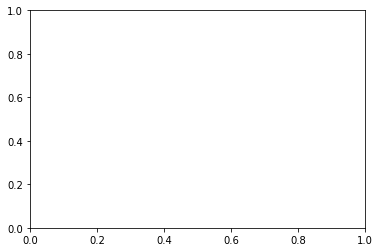

In [18]:
plt.plot(x_axis[1:1500], ls_dft_stream_files[1][1:1500])

In [15]:
print(len(ls_dft_stream[0]))
print('db =', 20*np.log10(np.abs(ls_dft_stream[0][0])))
print("Bin range for [0]:" + str(0) + "-" + str(100000/len(ls_dft_stream[0])))
print("Bin range for [1]:" + str(100000/len(ls_dft_stream[0])) + "-" +
                                        str(2*100000/len(ls_dft_stream[0])))
# 100000 is nyquist rate(1/2 * sample rate(Fs))


3000
db = 30.745347588575243
Bin range for [0]:0-33.333333333333336
Bin range for [1]:33.333333333333336-66.66666666666667


In [44]:
# to run this test part uncomment it:
# in_h = open('demoTethys.xq', 'rb')
# contents = in_h.readlines()
# in_h.close()
# print('contents =', contents)
# joined = b"".join(contents)
# print('\njoined =', joined)

# lines = joined.split(b'\n')
# print('\nlines =', lines)
# n = 1
# for l in lines:
#     print('%03d %s\n' %(n, l))
#     n = n+1

#### Asking Tethys with xquery to return freq and db of each preamp:

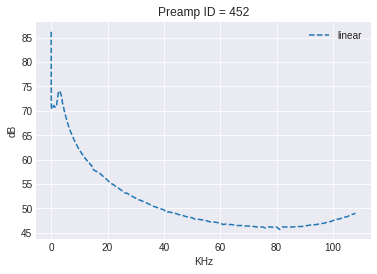

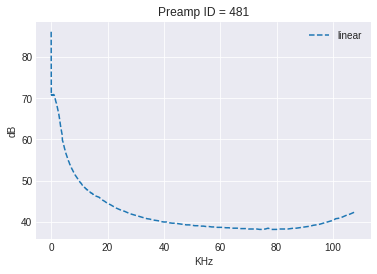

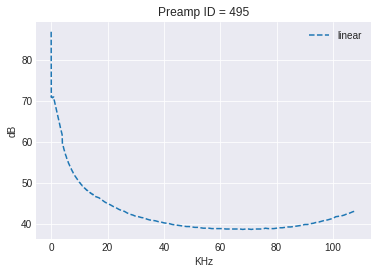

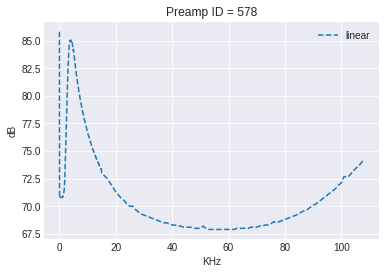

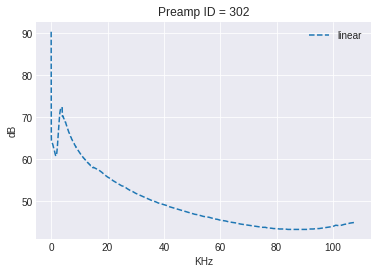

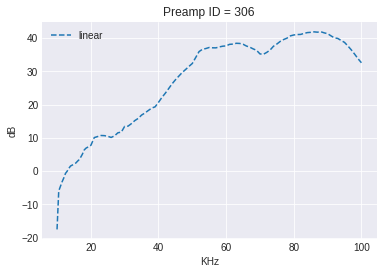

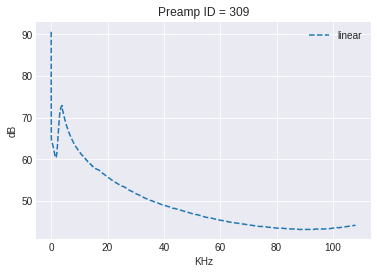

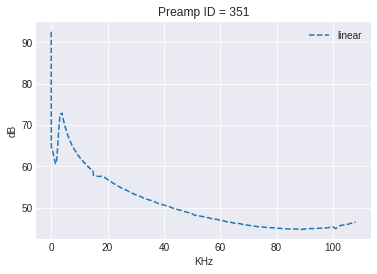

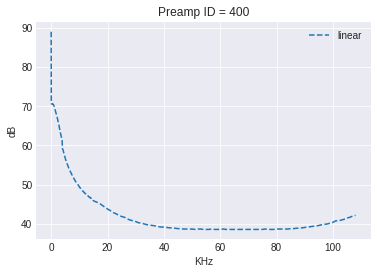

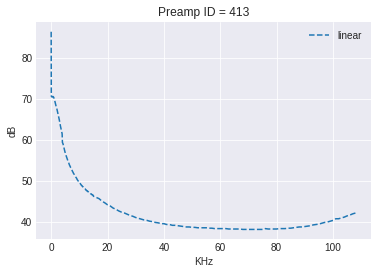

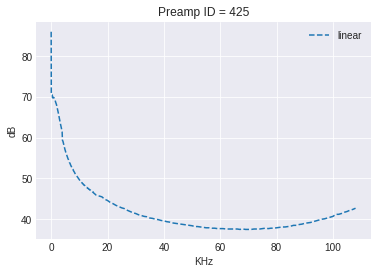

In [79]:
import requests
import re

import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


def read_file(file):
    in_h = open(file, 'rb')
    contents = in_h.readlines()
    in_h.close()
    joined = b''.join(contents)
    return joined  

def display_xquery(query):
    "Show query with line numbers"
    lines = query.split(b'\n')
    n = 1
    for l in lines:
#         print('%03d %s\n' %(n, l))
        n = n+1        
        

def xquery_REST(server, xquery):
    """query_REST - Run XQuery over REST
    server is server's URL
    xquery is the query string, must be UTF-8 encoded 
    (e.g. no 16 bit unicode)
    """
    url = server + "/XQuery"
    
    display_xquery(xquery)
    
    params = {"XQuery" : xquery}  # message parameters
    result = requests.post(url, params)
    
    if result.status_code != requests.codes.ok:
        print('error ocurred: %d'%(result.status_code))
        print(result.text)
        
    return result.text


server = 'http://bandolero.ucsd.edu:9779'
query = read_file('demoTethys.xq')

uniq_preamps = [b'ID=452',b'ID=481',b'ID=495',b'ID=578',
                b'ID=302',b'ID=306',b'ID=309',b'ID=351',
                b'ID=400',b'ID=413',b'ID=425']


query_files_per_preamp = []

for preamp in uniq_preamps:
    query_files_per_preamp.append(re.sub(b'ID=857', preamp, query))

parsed_Hz = []
parsed_Hz_arr = []
parsed_dB = []
parsed_dB_arr = []
preamp_dict = {}

for each_query in query_files_per_preamp:
    preamp_ID = re.search(b'(\d{3})',each_query).group(0).decode('utf')
#     print(preamp_ID)
    result_per_each_query = xquery_REST(server, each_query)
    
    match_Hz = re.search(r'(?<=Hz>)(.*?)(?=</Hz>)', 
                      result_per_each_query)

    match_dB = re.search(r'(?<=dB>)(.*?)(?=</dB>)', 
                      result_per_each_query)

    
    parsed_Hz = [float(Hz)/1000 for Hz in match_Hz.group().split()]
    
    parsed_dB = [float(dB) for dB in match_dB.group().split()]
#     print(parsed_Hz)
    parsed_Hz_arr.append(parsed_Hz)
    parsed_dB_arr.append(parsed_dB)
   

## dictionary of all the preamps with their freq and db:
    preamp_dict[preamp_ID] = {'Hz': parsed_Hz, 'dB': parsed_dB}
#     print(preamp_dict)
    
    ## linear iterploation of preamp spectra:
    f = interp1d(parsed_Hz, parsed_dB)
    
    
    ## plot the linear iterpolation per preamp:
    plt.plot(parsed_Hz, f(parsed_Hz), '--')
    plt.legend(['linear'], loc='best')
    plt.xlabel('KHz');plt.ylabel('dB')
    plt.title('Preamp ID = %s' %preamp_ID)
    plt.show()
    
    
   

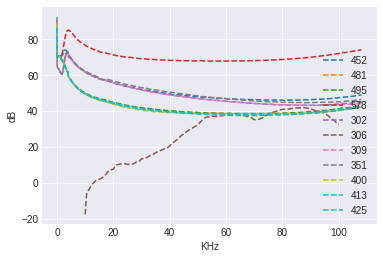

In [84]:
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('tab10')

# print(preamp_dict)
preamp_ls = []
freq = []
dB = []
for preamp in preamp_dict.keys():
    preamp_ls.append(preamp)
#     print(preamp_dict[preamp]['dB'])
    freq.append(preamp_dict[preamp]['Hz'])
    dB.append(preamp_dict[preamp]['dB'])



## plots of linear iterploation of preamps spectra:
for i in range(len(freq)):
    f = interp1d(freq[i], dB[i])
    plt.plot(freq[i], f(freq[i]), '--', color=palette(i))
    plt.legend(preamp_ls, loc='best')
    plt.xlabel('KHz')
    plt.ylabel('dB')

## Actual code- don't remove it!!!!

In [6]:
dot_c_ls = list(glob.iglob(fldr + '/**/*.c', recursive=True))

samples_for_all_files = []


# For each stream(we have 132 files --> 132 streams), 
# each detection(every row in every file) read the samples, that is:
# iterate through the the .x.wav files and make a list of all (132 files) 
# which inside every of those lists  for samples that has all 132 
# streams of 132 .x.wav files:
for counter, wav_file in enumerate(all_three):
    aa = SoundFile(wav_file)
    print(wav_file)
    #start is the absolute start time of the file(for example one of our 
    #files starts at 2007/11/4 05:30:00.000z)
    start = get_start_timestamp(wav_file)
    
    # declare the stream which will contain a list of all of the .x.wav 
    # files:
    stream_elements = Streams()
    stream_elements.add_file(wav_file, [len(aa)], [start], aa.samplerate)
    sound_stream = SampleStream(stream_elements)
    samples_for_current_file = []
    
    #iterate through 132 files:
    for detection in parse_start_end_detection(dot_c_ls)[counter]:
        
        #start_det is the relative seconds offset into the file 
        #(relative to the 'start' variable above)
        start_det = float(detection[0])
        end_det = float(detection[1])
        
        #start_timestamp is the absolute start time of the current detection
        start_timestamp = start + datetime.timedelta(seconds=start_det)
        sound_stream.set_time(start_timestamp)
        samps = sound_stream.read(int((end_det-start_det) * aa.samplerate))
        samples_for_current_file.append(samps)
    
    samples_for_all_files.append(samples_for_current_file)

/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061129_192230.x.wav


/mar/home/pzaeri/Parisa/dsp/dsp/SampleStream.py:383: RuntimeWarning: invalid value encountered in multiply
  self._hist = np.empty([self._hist_size, self.stream.channels]) * np.NaN


/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL10G_sitG_070118_181230.x.wav
/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL05A_sitA_061019_212500.x.wav
/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL10G_sitG_070120_163000.x.wav
/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL19G_sitG_071210_191615.x.wav
/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL10G_sitG_070120_174230.x.wav
/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL10G_sitG_070124_114230.x.wav
/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061129_173000.x.wav
/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL05A_sitA_061018_214000.x.wav
/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL10G_sitG_070118_170000.x.wav
/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL10G_sitG_070124_153000.x.wav
/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061115_002500.x.wav
/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL10G_sitG_070121_12300

KeyboardInterrupt: 

In [4]:
start_timestamp = []

for wav_file in all_three:
    start_timestamp.append(get_start_timestamp(wav_file))
# print(start_timestamp)

print(start_timestamp[5])
print(all_three[5])


# first_t_stamp = get_start_timestamp(first,format_str="%y%m%d_%H%M%S")
# first_t_stamp

2007-01-20 17:42:30
/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL10G_sitG_070120_174230.x.wav


<br><br>

`parse_start_end_time()` is a function that takes all of `.extension` files  as an argument and loop through each one of the `.c` files and extract 1st and 2nd elemtents of each line, make them into a tuple `(start_time, end_time)` and append all of them into a list `start_end_time`:

In [5]:
def parse_start_end_detection(dot_ext_path_ls):
    start_end_det = []
    for dot_file in dot_ext_path_ls:
        with open(dot_file, 'r') as file:
            this_file = []
            for line in file:
                elements = line.split()
                start_det = elements[0]
                end_det = elements[1]
                this_file.append((start_det, end_det))
        start_end_det.append(this_file)
    return start_end_det

 `dot_c_ls` below ia a list of `.c` files in those three paths:

In [6]:
dot_c_ls = list(glob.iglob(fldr + '/**/*.c', recursive=True))
print(len(dot_c_ls))

start_end_ls = parse_start_end_detection(dot_c_ls)
# print(start_end_ls)
len(start_end_ls[8])

# How can I sort them?
# start_end_ls.sort()



132


9693

In [45]:
print(dot_c_ls[-1])
print(len(start_end_ls[-1]))

/mar/lab/corpora/SitePreamp/pacific_white-sided_a/SOCAL32E_sitE_090426_050615.c
689


In [16]:
server = 'http://bandolero.ucsd.edu:9779'
url = server + '/XQuery'

def build_xquery(project, deployment, site):
    return '''
    (: import Tethys schema so we have type information about the docuements :)
    import schema namespace ty="http://tethys.sdsu.edu/schema/1.0" at "tethys.xsd";
    (: import utility functions :)
    import module namespace lib="http://tethys.sdsu.edu/XQueryFns" at "Tethys.xq";

    for $deployment in collection("Deployments")/ty:Deployment
       where $deployment/Project = "'''+project+'''" and
         $deployment/DeploymentID = '''+str(deployment)+''' and
         $deployment/Site = "'''+str(site)+'''" return
         <preamp>
         {$deployment/Sensors/Audio/PreampID}
         </preamp>
    '''

In [17]:
# Construct the query:
def parsing_wav(wav_ls):
    project = []
    deployment = []
    site = []
    for string in wav_ls:
        match = re.search(r'([A-Za-z]{4,5})(\d{2})([\w\d]+?)_', string)       
        if match:
            if(match.group(1) == "SCAL"):
                project.append("SOCAL")
            else:
                project.append(match.group(1))
            deployment.append(match.group(2))
            site.append(match.group(3))
        deployment = [int(i) for i in deployment]
    
    #print('project = %s' %project, '\n','\n', 'deployment = %s' %deployment, '\n','\n'  'site = %s' %site, '\n','\n', '\n')
    return project, deployment, site

In [19]:
def GetPreampFromResult(result):
    return ET.fromstring(result.text)[0].text

In [20]:
project, deployment, site = parsing_wav(all_three)
#print('project = ', project,'\n', 'deployment = ', deployment,'\n', 'site = ', site)
results = []
for i in range(len(all_three)):
    q = build_xquery(project[i], deployment[i], site[i])
    params = {'XQuery' : q}  # message parameters
    result = requests.post(url, params)
    results.append(result)
    #print(result)

In [43]:
print('uniq_deployments =', sorted(list(set(deployment))))
print('Nember of uniq_deployment =', len(np.unique(deployment)))
print('uniq_sites =', sorted(list(set(np.unique(site)))))
print('Number of uniq_sites =', len(np.unique(site)))

uniq_deployments = [4, 5, 8, 10, 15, 19, 31, 32, 33, 35]
Nember of uniq_deployment = 10
uniq_sites = ['A', 'E', 'G', 'G2', 'M', 'SN']
Number of uniq_sites = 6


**I don't have site `H` and preamps `560`, `588`, `662`, `676` in my dataset!!**

In [49]:
preamp_list = []

for i in range(len(results)):
    if(results[i].text != ''):
        preamp_list.append(GetPreampFromResult(results[i]))
    else:
        print("No response for index: " + str(i))
        print(project[i], deployment[i], site[i])  
        
print('preamp_list =', sorted(preamp_list), '\n')
print('uniq_preamps =', np.unique(preamp_list), '\n')
print('Number of uniq_preamp =', len(np.unique(preamp_list)))

preamp_list = ['452', '452', '452', '452', '452', '452', '452', '452', '452', '452', '452', '452', '452', '452', '452', '452', '452', '481', '481', '481', '481', '481', '481', '481', '495', '495', '495', '495', '495', '578', '578', '578', '578', 'H302', 'H302', 'H302', 'H302', 'H302', 'H302', 'H306', 'H306', 'H306', 'H306', 'H306', 'H306', 'H306', 'H306', 'H306', 'H306', 'H306', 'H306', 'H309', 'H309', 'H309', 'H309', 'H309', 'H309', 'H309', 'H309', 'H309', 'H309', 'H309', 'H309', 'H309', 'H309', 'H309', 'H309', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H351', 'H400', 'H400', 'H400', 'H400', 'H413', 'H413', 'H413', 'H413', 'H413', 'H413', 'H413', 'H413', 'H413', 'H413', 'H413', 'H413', 'H413', 'H413', 'H413', 'H413', 'H413', 'H413', 'H425', 'H425', 'H425', 'H425', 'H425', 'H425', 'H425', 'H425', 'H425', 'H425', 'H425', 'H

In [190]:
results[0].text

'<preamp><PreampID xmlns:ty="http://tethys.sdsu.edu/schema/1.0" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">H309</PreampID></preamp>'

#### Now we want to create a dictionary with using `defaultdict(list)` from `defaultdict` module that `key` are each one of the element in the `preamp_list` and `vallue` is a list of files in `all_three`  that are refering to set `preamp_set`:  

In [180]:
preamp_list

['H309',
 'H351',
 'H306',
 'H351',
 'H413',
 'H351',
 'H351',
 'H309',
 'H306',
 'H351',
 'H351',
 'H309',
 'H351',
 '578',
 'H351',
 'H309',
 'H306',
 'H309',
 'H309',
 'H425',
 'H306',
 'H309',
 'H309',
 'H351',
 'H425',
 'H425',
 'H351',
 'H351',
 'H351',
 '578',
 'H425',
 'H309',
 'H309',
 'H309',
 'H351',
 'H413',
 'H306',
 'H351',
 'H413',
 'H351',
 'H413',
 'H351',
 'H309',
 'H400',
 'H351',
 'H306',
 'H400',
 '578',
 'H425',
 '452',
 'H425',
 'H425',
 '452',
 'H306',
 'H425',
 'H425',
 '481',
 'H425',
 'H302',
 'H425',
 'H425',
 'H425',
 'H302',
 'H309',
 '481',
 'H413',
 'H302',
 'H302',
 'H309',
 'H306',
 'H413',
 '481',
 '481',
 'H413',
 'H309',
 'H309',
 '481',
 '452',
 'H425',
 'H306',
 'H306',
 'H425',
 'H425',
 'H400',
 'H306',
 'H400',
 'H306',
 'H413',
 'H302',
 '452',
 'H302',
 '495',
 '452',
 'H351',
 'H413',
 '452',
 '452',
 'H413',
 '481',
 'H351',
 '495',
 'H351',
 '481',
 '452',
 'H413',
 '495',
 '495',
 '452',
 '452',
 'H413',
 '578',
 '452',
 'H413',
 'H351',


In [194]:
preamp_set = set(preamp_list)
print('preamp_set = ', preamp_set)

preamp_set =  {'H309', 'H351', '578', 'H306', '481', '452', '495', 'H413', 'H302', 'H400', 'H425'}


In [195]:
preamp_dict = defaultdict(list)
for s in preamp_set:
    for i in range(len(preamp_list)):
        if(preamp_list[i] == s):
            preamp_dict[s].append(all_three[i])
            
print('preamp_dict = ', preamp_dict)

preamp_dict =  defaultdict(<class 'list'>, {'H309': ['/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061129_192230.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061129_173000.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061115_002500.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061114_234730.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061114_164615.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061112_225345.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061129_200000.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061112_233115.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061129_180730.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061114_160845.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061115_01023

In [197]:
print('list of files for preamp H309:', preamp_dict['H309'])

list of files for preamp H309: ['/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061129_192230.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061129_173000.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061115_002500.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061114_234730.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061114_164615.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061112_225345.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061129_200000.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061112_233115.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061129_180730.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061114_160845.x.wav', '/mar/lab/corpora/SitePreamp/pacific_white-sided_b/SOCAL08A_sitA_061115_010230.x.wav', '/mar/lab/c

<br><br>